In [25]:
# General
import os
import re
import sklearn
import nltk
import numpy as np
import pandas as pd
import contractions
# Preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
# models
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist
# Plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn
import seaborn as sns
# Enable inline plotting  
%matplotlib inline

In [26]:
data1 = pd.read_csv('train/tweet_global_warming.csv',error_bad_lines=False,engine='python')
data2 = pd.read_csv('train/weather-evaluated-agg-DFE.csv',encoding='utf-8')
data3 = pd.read_csv('train/sentiment_nuclear_power.csv',error_bad_lines=False,engine='python')

In [27]:
data = pd.concat([data1['tweet'],data2['tweet_text'],data3['tweet_text']],axis=0)
data = shuffle(data)
data.index = range(len(data))

In [28]:
data.head()

0    BLOG UPDATE: {link} What's the difference betw...
1    Stossel Show - Global Warming! The high cost t...
2    Today, give a stranger one of your smiles. It ...
3    C3: New Mexico's Democrats/Liberals Push Globa...
4    Panel Debates Business Cost Of Calif. Global W...
dtype: object

## Preprocess

In [29]:
stopword = stopwords.words('english') 

In [30]:
def stemming(words):
    ps = nltk.stem.SnowballStemmer('english')
    new = []
    stem_words = [ps.stem(x) for x in words]
    return stem_words

In [31]:
def preprocess(sentence):
    sentence = contractions.fix(sentence)             # Replace contractions in string 
    sentence = re.sub('@\w+',"",str(sentence))        # remove mentions
    sentence = re.sub('#\w+',"",str(sentence))        # remove hashtags
    sentence = re.sub('http\S+',"",str(sentence))     # remove URLs
    sentence = re.sub('[^\w\s]'," ",str(sentence))    # remove punc
    sentence = re.sub('[^a-zA-Z]'," ",str(sentence))  # remove numbers
  
    sents = word_tokenize(sentence)                   # Tokenization
    sents = stemming(sents)
            
    new_sents = ""
    for i in range(len(sents)):                       # remove stopwords            
        if(sents[i].lower() not in stopword and sents[i]!='rt' and len(sents[i])>1):
            new_sents += sents[i].lower()+" "
    new_sents.strip()
    
    return new_sents

In [32]:
def preprocessing(xtrain):
    corpus = xtrain.apply(preprocess)
    return corpus

In [33]:
corpus = preprocessing(data)
corpus = corpus.drop_duplicates() 

## Feature Extraction

In [34]:
def featureextraction(corpus):
    
    vectorizer = TfidfVectorizer(max_df=.5,min_df=1,max_features=None,ngram_range=(1, 2),norm=None,binary=True,
                             use_idf=False,sublinear_tf=False,strip_accents = 'unicode',stop_words = 'english')
    vectorizer = vectorizer.fit(corpus)
    tfidf = vectorizer.transform(corpus)
    vocab = vectorizer.get_feature_names()

    return tfidf, vocab

In [35]:
tfidf, vocab = featureextraction(corpus)

## Agglomerative Hierarchical Clustering

__Pros__:
1) No assumption of a particular number of clusters (i.e. k-means)<br>
2) May correspond to meaningful taxonomies<br>
__Cons__:
1) Too slow for large data sets, O(𝑛2 log(𝑛))

The version of hierarchical clustering we will explore is called agglomerative clustering. Although Scikit-Learn has a library for this, it performs very slowly. Instead, we will choose to use another version of hierarchical clustering called fastcluster. This package is a C++ library with an interface in Python/SciPy.<br>
For more information, look here:<br>
http://danifold.net/fastcluster.html?section=1

User Manual:<br>
https://cran.r-project.org/web/packages/fastcluster/vignettes/fastcluster.pdf

In [37]:
pca = PCA(n_components=None).fit(tfidf.todense())
reduc = pca.transform(tfidf.todense())

In [44]:
def pca_variance(pca,reduc,plot_var):
    var_exp = pca.explained_variance_ratio_*100
    cum_var_exp = np.cumsum(pca.explained_variance_ratio_)*100
    
    if plot_var:
        with plt.style.context('seaborn-whitegrid'):
            fig, ax = plt.subplots(figsize=(6, 4))
            plt.bar(range(len(var_exp)), var_exp, alpha=0.5, align='center',
                    label='individual explained variance')
#             plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',
#                      label='cumulative explained variance')
            plt.ylabel('Explained variance ratio')
            plt.xlabel('Principal components')
            plt.xticks(range(len(var_exp)))
            ax.set_xticklabels(np.arange(1, reduc.shape[1] + 1))
            plt.legend(loc='best')
            plt.tight_layout()
            plt.ylim([0,1])
            plt.xlim([0,100])
        
    return var_exp

array([7.19812670e+00, 2.01922930e+00, 9.66340359e-01, ...,
       1.23225099e-33, 6.75814744e-34, 6.73598687e-35])

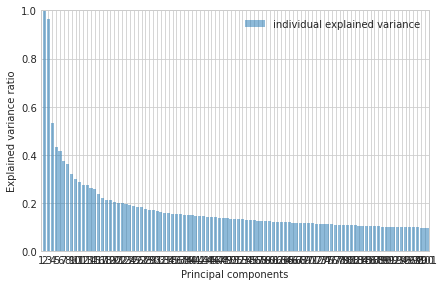

In [45]:
pca_variance(pca,reduc,True)

In [36]:
pca = PCA(n_components=50).fit_transform(tfidf.todense())

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/mahzadkhoshlessan/miniconda3/envs/omdena/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-140304e8428e>", line 1, in <module>
    pca = PCA(n_components=50).fit_transform(tfidf.todense())
  File "/Users/mahzadkhoshlessan/miniconda3/envs/omdena/lib/python3.8/site-packages/sklearn/decomposition/_pca.py", line 369, in fit_transform
    U, S, V = self._fit(X)
  File "/Users/mahzadkhoshlessan/miniconda3/envs/omdena/lib/python3.8/site-packages/sklearn/decomposition/_pca.py", line 418, in _fit
    return self._fit_truncated(X, n_components, self._fit_svd_solver)
  File "/Users/mahzadkhoshlessan/miniconda3/envs/omdena/lib/python3.8/site-packages/sklearn/decomposition/_pca.py", line 543, in _fit_truncated
    total_var = np.var(X, ddof=1, axis=0)
  File "<__array_function__ internals>", line 5, in var
  File "/Users/mahzadkhoshles

KeyboardInterrupt: 

In [14]:
Z = fastcluster.linkage_vector(pca,method='ward', metric='euclidean')

In [17]:
Z_dataFrame = pd.DataFrame(data=Z, 
    columns=['clusterOne','clusterTwo','distance','newClusterSize']) 

In [15]:
Z

array([[4.10200000e+03, 5.85400000e+03, 0.00000000e+00, 2.00000000e+00],
       [2.06400000e+03, 3.46200000e+03, 0.00000000e+00, 2.00000000e+00],
       [4.19100000e+03, 4.34300000e+03, 0.00000000e+00, 2.00000000e+00],
       ...,
       [1.19810000e+04, 1.20310000e+04, 3.05958559e+01, 2.44800000e+03],
       [1.20330000e+04, 1.20340000e+04, 7.10513183e+01, 3.74600000e+03],
       [1.20320000e+04, 1.20350000e+04, 1.07098773e+02, 6.01900000e+03]])

### Dendrograms 

We can use a dendrogram to visualize the history of groupings and figure out the optimal number of clusters. <br>
1) Determine the largest vertical distance that doesn’t intersect any of the other clusters<br>
2) Draw a horizontal line at both extremities<br>
3) The optimal number of clusters is equal to the number of vertical lines going through the horizontal line

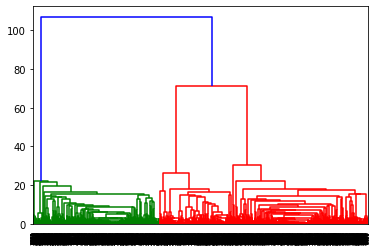

In [16]:
dend = dendrogram(Z)

Following the above procedures and the Dendogram above the optimum number of clusters is __three__.

In [18]:
from scipy.cluster.hierarchy import fcluster

distance_threshold = 35
clusters = fcluster(Z, distance_threshold, criterion='distance')

In [19]:
clusters

array([1, 3, 3, ..., 1, 1, 2], dtype=int32)

In [20]:
len(clusters)

6019

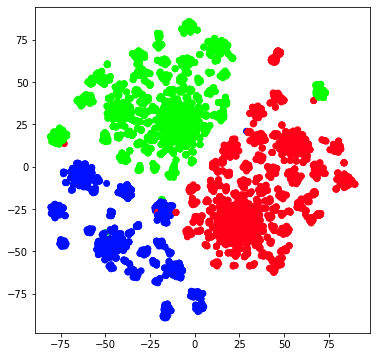

In [24]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))
tsne = TSNE().fit_transform(pca)
max_label = max(clusters)
label_subset = [cm.hsv(i/max_label) for i in clusters]
ax.scatter(tsne[:, 0], tsne[:, 1], c=label_subset)